In [25]:
#!pip install -U featuretools
#!python -m pip install graphviz

In [203]:
import pandas as pd
import numpy as np
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import matplotlib.pyplot as plt


from woodwork.logical_types import Categorical, PostalCode
from pandas.plotting import table


# Data Set
Source: https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-tutorial

Tables:
* clients: information about clients at a credit union
* loans: previous loans taken out by the clients
* payments: payments made/missed on the previous loans


In [206]:
# Load Data
clients = pd.read_csv('./data/clients.csv', parse_dates = ['joined'])
clients['joined'] = pd.to_datetime(clients['joined']).dt.date

loans = pd.read_csv('./data/loans.csv', parse_dates = ['loan_start', 'loan_end'])
loans['loan_start'] = pd.to_datetime(loans['loan_start']).dt.date
loans['loan_end'] = pd.to_datetime(loans['loan_end']).dt.date

payments = pd.read_csv('./data/payments.csv', parse_dates = ['payment_date'])
payments['payment_date'] = pd.to_datetime(payments['payment_date']).dt.date



# payments add index as column
payments['payment_id'] = payments.index

## move payment_id to first column
cols = payments.columns.tolist()
cols = cols[-1:] + cols[:-1]
payments = payments[cols]


payments_due = payments[['payment_id', 'loan_id', 'payment_date','payment_amount']]
payments_due.columns = ['payment_id', 'loan_id', 'due_date', 'amount_due']
payments_due


outcome = payments[payments['missed'] == 1][['payment_id','payment_date']]
outcome.columns = ['payment_id', 'outcome_time']
# subtract 1 day from cutoff_time to avoid leakage
outcome['outcome_time'] = outcome['outcome_time'] + pd.Timedelta(days=1)

outcome.reset_index(drop=True, inplace=True)
outcome['order_id'] = outcome.index

cols = outcome.columns.tolist()
cols = cols[-1:] + cols[:-1]
outcome = outcome[cols]

In [208]:
# Sample data
# Specify the customer and loans of interest
customer_id = 26326
loans_of_interest = [11251,11988]
#loans_of_interest = loans[(loans['client_id'] == customer_id)]['loan_id']

# Filter data for the specified customer and loans
clients_subset = clients[clients['client_id'] == customer_id]
loans_subset = loans[(loans['loan_id'].isin(loans_of_interest))].sort_values(by = 'loan_start')

payments_due_subset = payments_due[payments_due['loan_id'].isin(loans_of_interest)]
outcome_subset = outcome[outcome['payment_id'].isin(payments_due_subset['payment_id'])]



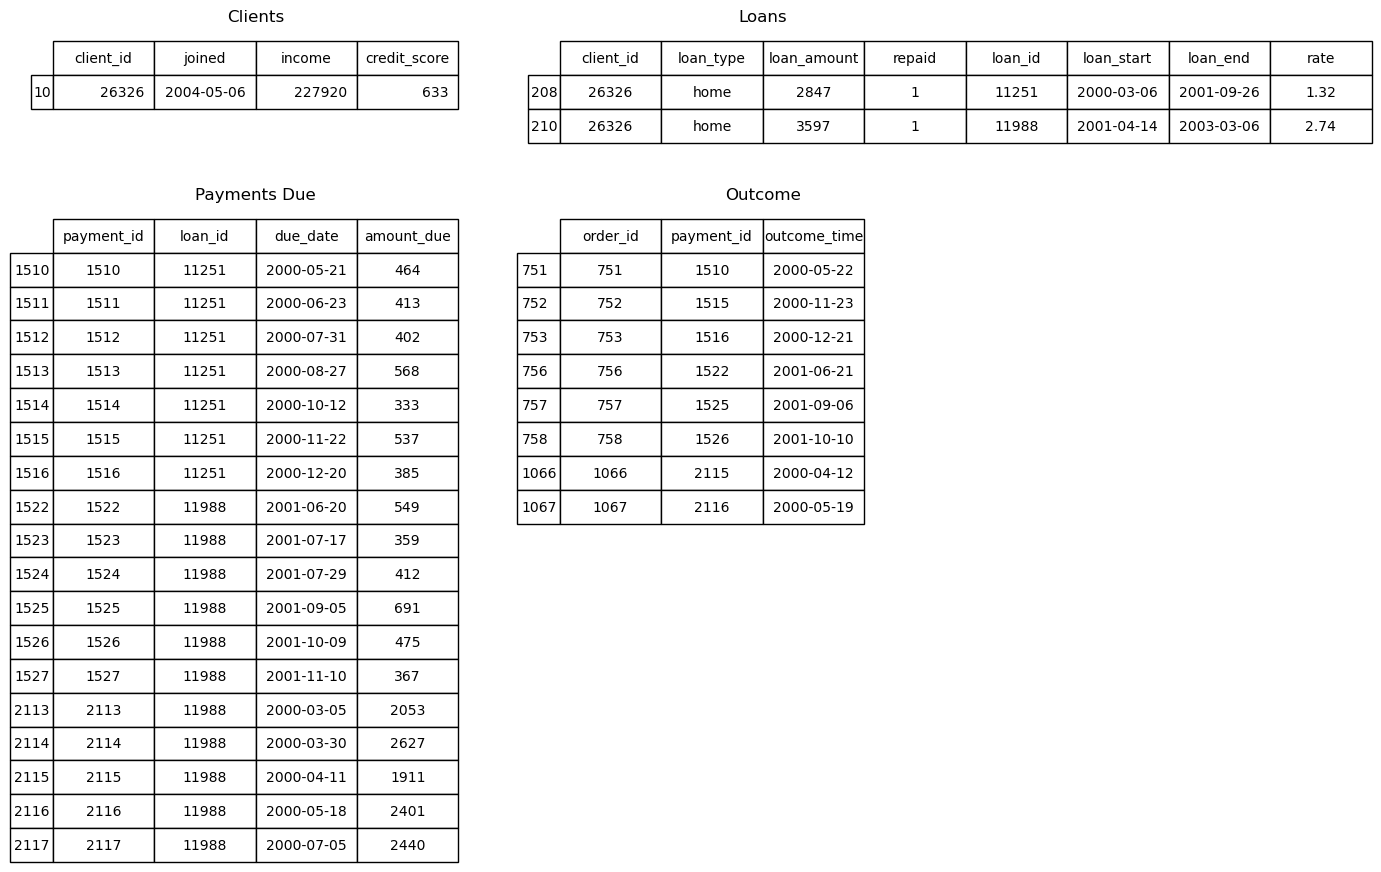

In [234]:
# Sample data (assuming you have these DataFrames)
# clients_subset, loans_subset, payments_due_subset, outcome_subset

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

# Plot Clients Subset
table_clients = table(axes[0, 0], clients_subset, loc='upper left', colWidths=[0.2]*len(clients_subset.columns))
table_clients.auto_set_font_size(False)
table_clients.set_fontsize(10)
table_clients.scale(1.2, 1.2)
axes[0, 0].set_title('Clients')

# Plot Loans Subset
table_loans = table(axes[0, 1], loans_subset, loc='upper left', colWidths=[0.2]*len(loans_subset.columns), cellLoc='center')
table_loans.auto_set_font_size(False)
table_loans.set_fontsize(10)
table_loans.scale(1.2, 1.2)
axes[0, 1].set_title('Loans')

# Plot Payments Due Subset
table_payments_due = table(axes[1, 0], payments_due_subset, loc='upper left', colWidths=[0.2]*len(payments_due_subset.columns), cellLoc='center')
table_payments_due.auto_set_font_size(False)
table_payments_due.set_fontsize(10)
table_payments_due.scale(1.2, 1.2)
axes[1, 0].set_title('Payments Due')

# Plot Outcome Subset
table_outcome = table(axes[1, 1], outcome_subset, loc='upper left', colWidths=[0.2]*len(outcome_subset.columns), cellLoc='center')
table_outcome.auto_set_font_size(False)
table_outcome.set_fontsize(10)
table_outcome.scale(1.2, 1.2)
axes[1, 1].set_title('Outcome')

# Adjust layout with reduced vertical space between top and bottom tables
plt.subplots_adjust(hspace=-0.7)

# Show the plot
plt.show()


## Data Representation with EntitySets
An EntitySet is a collection of dataframes and the relationships between them. They are useful for preparing raw, structured datasets for feature engineering. While many functions in Featuretools take dataframes and relationships as separate arguments, it is recommended to create an EntitySet, so you can more easily manipulate your data as needed.



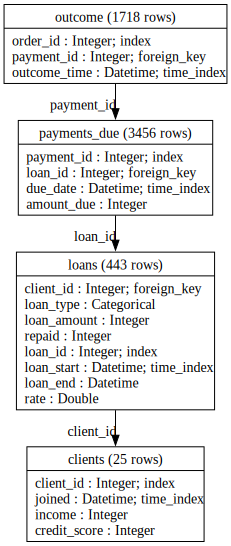

In [235]:
es = ft.EntitySet(id = 'clients')

## Entities Dataframe
es = es.add_dataframe(
    dataframe_name="clients",
    dataframe=clients,
    index="client_id",
    time_index="joined")

es = es.add_dataframe(
    dataframe_name="loans",
    dataframe=loans,
    index="loan_id",
    time_index="loan_start")

es = es.add_dataframe(
    dataframe_name="payments_due",
    dataframe=payments_due,
    index="payment_id",
    time_index="due_date")

es = es.add_dataframe(
    dataframe_name="outcome",
    dataframe=outcome,
    time_index="outcome_time")


## Adding Relationships in dataframes

# Relationship between clients and previous loans
ed = es.add_relationship('clients', 'client_id', 'loans', 'client_id')

# Relationship between previous loans and payments
es = es.add_relationship('loans', 'loan_id', 'payments_due', 'loan_id')

# Relationship between payments and outcome
es = es.add_relationship('payments_due', 'payment_id', 'outcome', 'payment_id')


es.plot()


# Feature primitives
Feature primitives are the building blocks of Featuretools. They define individual computations that can be applied to raw datasets to create new features. Because a primitive only constrains the input and output data types, they can be applied across datasets and can stack to create new calculations.

Feature primitives fall into two categories:

1. Aggregation: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
2. Transformation: an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

In [211]:
primitives = ft.list_primitives()
# Set the maximum number of rows and columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [212]:
# Aggregation primitives
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,max_consecutive_true,aggregation,False,False,Determines the maximum number of consecutive T...,<ColumnSchema (Logical Type = Boolean)>,<ColumnSchema (Logical Type = Integer) (Semant...
1,n_unique_months,aggregation,False,False,Determines the number of unique months.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semant...
2,count,aggregation,True,True,"Determines the total number of values, excludi...",<ColumnSchema (Semantic Tags = ['index'])>,<ColumnSchema (Logical Type = IntegerNullable)...
3,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
4,time_since_last_true,aggregation,False,False,Calculates the time since the last `True` value.,"<ColumnSchema (Logical Type = Boolean)>, <Colu...",<ColumnSchema (Logical Type = Double) (Semanti...
5,first_last_time_delta,aggregation,False,False,Determines the time between the first and last...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = Double) (Semanti...
6,count_below_mean,aggregation,False,False,Determines the number of values that are below...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable)...
7,n_unique_days,aggregation,False,False,Determines the number of unique days.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semant...
8,percent_true,aggregation,True,False,Determines the percent of `True` values.,"<ColumnSchema (Logical Type = Boolean)>, <Colu...",<ColumnSchema (Logical Type = Double) (Semanti...
9,std,aggregation,True,True,Computes the dispersion relative to the mean v...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>


In [213]:
# transform primitives
primitives[primitives['type'] == 'transform'].head(10)

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
65,season,transform,False,False,Determines the season of a given datetime. Ret...,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Categorical) (Se...
66,diff_datetime,transform,False,False,Computes the timedelta between a datetime in a...,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Timedelta)>
67,age,transform,True,False,Calculates the age in years as a floating poin...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = AgeFractional) (...
68,divide_by_feature,transform,True,True,Divides a scalar by each value in the list.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
69,modulo_numeric_scalar,transform,True,True,Computes the modulo of each element in the lis...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
70,rolling_mean,transform,False,False,Calculates the mean of entries over a given wi...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = Double) (Semanti...
71,count_string,transform,False,False,Determines how many times a given string shows...,<ColumnSchema (Logical Type = NaturalLanguage)>,<ColumnSchema (Logical Type = IntegerNullable)...
72,time_since_previous,transform,False,False,Computes the time since the previous entry in ...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Semantic Tags = ['numeric'])>
73,exponential_weighted_variance,transform,False,False,Computes the exponentially weighted moving var...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semanti...
74,sine,transform,True,True,Computes the sine of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semanti...


In [214]:
# Take the index and the appointment time to use as a cutoff time
cutoff_times = es['payments_due'][['payment_id', 'due_date']].sort_values(by='due_date')

# Rename columns to avoid confusion
cutoff_times.rename(columns = {'due_date': 'time'},
                    inplace = True)
cutoff_times.head()

# subtract 1 day from the time
cutoff_times['time'] = cutoff_times['time'] - pd.Timedelta(0, 'days')
payments_due

,payment_id,loan_id,due_date,amount_due
2113,2113,11988,2000-03-05,2053
726,726,11140,2000-03-19,402
2114,2114,11988,2000-03-30,2627
3223,3223,11430,2000-04-05,1284
2115,2115,11988,2000-04-11,1911
...,...,...,...,...
1415,1415,11072,2015-07-01,957
1308,1308,10684,2015-07-06,115
1416,1416,11072,2015-07-14,988
1417,1417,11072,2015-07-29,940


In [231]:
## Create feature per payment entry

agg_primitives =  ["sum","count","max"]
trans_primitives = ["time_since_previous"]#["time_since_previous"]

# Deep feature synthesis 
f, feature_names = ft.dfs(entityset=es, target_dataframe_name='payments_due',
                       agg_primitives = agg_primitives,
                       trans_primitives = trans_primitives,
                       n_jobs = -1, verbose = 1,
                       cutoff_time = cutoff_times,                    
                       cutoff_time_in_index = True,
                       max_depth = 2)
feature_names

Built 13 features
Elapsed: 00:00 | Progress:   0%|          

EntitySet scattered to 8 workers in 29 seconds
Elapsed: 03:00 | Progress: 100%|██████████


[<Feature: loan_id>,
 <Feature: amount_due>,
 <Feature: COUNT(outcome)>,
 <Feature: loans.client_id>,
 <Feature: loans.loan_type>,
 <Feature: loans.loan_amount>,
 <Feature: loans.repaid>,
 <Feature: loans.rate>,
 <Feature: loans.COUNT(payments_due)>,
 <Feature: loans.SUM(payments_due.amount_due)>,
 <Feature: loans.COUNT(outcome)>,
 <Feature: loans.clients.income>,
 <Feature: loans.clients.credit_score>]

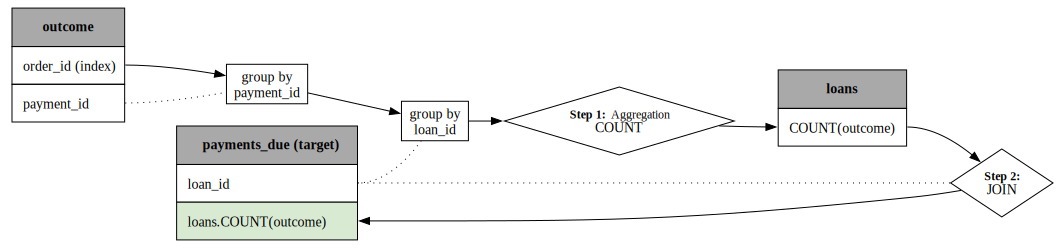

In [232]:
# Visualize the feature
graph_feature = ft.graph_feature(feature_names[10])
graph_feature

In [233]:
f.reset_index(inplace = True)
f[f.payment_id == 1512].head(10)

,payment_id,time,loan_id,amount_due,COUNT(outcome),loans.client_id,loans.loan_type,loans.loan_amount,loans.repaid,loans.rate,loans.COUNT(payments_due),loans.SUM(payments_due.amount_due),loans.COUNT(outcome),loans.clients.income,loans.clients.credit_score
27,1512,2000-07-31,11251,402,0,26326,home,2847,1,1.32,3,1279.0,1,<NA>,<NA>


In [196]:
clients_subset
loans_subset
payments_due[payments_due['payment_id'] == 1512]



,payment_id,loan_id,due_date,amount_due
1512,1512,11251,2000-07-31,402


In [200]:
outcome[outcome['payment_id'] == 1512]


,new_index,order_id,payment_id,outcome_time,payed


In [218]:
loans[loans['loan_id'] == 11251]


,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
11251,26326,home,2847,1,11251,2000-03-06,2001-09-26,1.32


In [220]:
payments_due[payments_due['loan_id'] == 11251].sort_values(by = 'due_date')


,payment_id,loan_id,due_date,amount_due
1510,1510,11251,2000-05-21,464
1511,1511,11251,2000-06-23,413
1512,1512,11251,2000-07-31,402
1513,1513,11251,2000-08-27,568
1514,1514,11251,2000-10-12,333
1515,1515,11251,2000-11-22,537
1516,1516,11251,2000-12-20,385


In [71]:

loans[loans['client_id'] == 26326]


,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
11251,26326,home,2847,1,11251,2000-03-06,2001-09-26,1.32
11988,26326,home,3597,1,11988,2001-04-14,2003-03-06,2.74
11655,26326,credit,13464,0,11655,2001-10-06,2004-03-25,2.13
11024,26326,cash,8794,0,11024,2003-04-25,2005-07-20,1.63
10491,26326,cash,6147,1,10491,2003-06-01,2005-07-15,3.24
...,...,...,...,...,...,...,...,...
10543,26326,other,13264,1,10543,2011-07-09,2013-06-05,0.78
11386,26326,other,10261,1,11386,2013-05-17,2015-10-07,0.74
11960,26326,other,1164,0,11960,2014-08-02,2017-01-29,0.50
11559,26326,other,10902,1,11559,2014-09-06,2016-11-14,6.73


In [67]:
clients[clients['client_id'] == 26326]

,client_id,joined,income,credit_score
26326,26326,2004-05-06,227920,633


In [92]:
#Changing Target DataFrame
#DFS is powerful because we can create a feature matrix for any dataframe in our dataset. If we switch our target dataframe to “sessions”, we can synthesize features for each session instead of each customer. Now, we can use these features to predict the outcome of a session.

